### Import required libraries and necessary packages

In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.applications import VGG19
from keras.layers import AveragePooling2D,MaxPool2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

### Load The data

In [3]:
# The path of our data on drive
data_dir =  r'E:\coviddataset1\COVID-19_Dataset\dataset'
 
# Loading Data
data = load_files(data_dir)

In [12]:
folders=os.listdir("E:\coviddataset1\COVID-19_Dataset\dataset")
print(folders)

['covid_images', 'normal_images', 'viral_images']


In [8]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  E:\coviddataset1\COVID-19_Dataset\dataset\normal_images\Normal-5551.png
Target labels -  1
Number of training files :  12315
Number of training targets :  12315


### Convert images to arrays

In [9]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 100,100 
    #Loop over the image paths
    for file_path in file_path_list:
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
    return arr
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(12315, 100, 100, 3)
First training item :  [[[104. 104. 104.]
  [ 74.  74.  74.]
  [ 58.  58.  58.]
  ...
  [142. 142. 142.]
  [150. 150. 150.]
  [159. 159. 159.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [ 74.  74.  74.]
  [ 82.  82.  82.]
  [100. 100. 100.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 ...

 [[  2.   2.   2.]
  [  1.   1.   1.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]

 [[  2.   2.   2.]
  [  2.   2.   2.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]

 [[  2.   2.   2.]
  [  2.   2.   2.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]]


### Take a look at some pictures

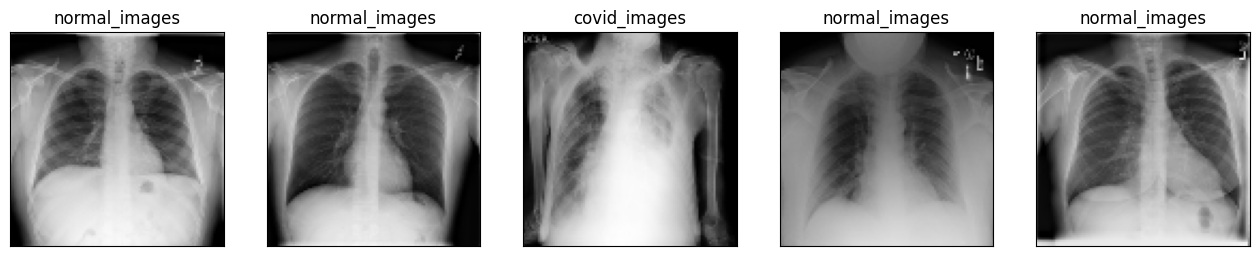

In [13]:
#Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [14]:
"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

3

In [15]:
y

array([1, 1, 0, ..., 1, 1, 0])

In [16]:
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1., 0.], dtype=float32)

In [17]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  9852
The validation Data Shape  1232
The test Data Shape  1231


In [18]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (100, 100, 3)


### Fine tuning VGG19 pre-trained model
>Here we are going to use [**Transfer Learning**](https://keras.io/guides/transfer_learning/) with advanced and popular VGG19 architecture with pre-trained weights on the popular **ImageNet** dataset. Then adapt it to our dataset. So, it will be our base Model

In [19]:
VGG19_model = keras.applications.VGG19(input_shape= X_train.shape[1:], include_top=False, weights="imagenet")
# setting the VGG model to be untrainable.
VGG19_model.trainable = False

In [20]:
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [21]:
from keras.layers import BatchNormalization
Model = Sequential()
Model.add(VGG19_model)
Model.add(BatchNormalization())
Model.add(Dropout(0.20))
Model.add(Flatten())
Model.add(Dense(256,activation='relu'))
Model.add(Dense(3,activation='softmax'))
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                        

In [22]:
bs = 8
optimizer = "Adam"
Model.compile(optimizer, loss = 'binary_crossentropy' , metrics = ['accuracy'])

---

In [23]:
epochs = 10
train_datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    horizontal_flip=True)
 
checkpointer = ModelCheckpoint(filepath = "C:/Users/HP/Downloads/COVID-19-Detection-From-X-Ray-master/COVID-19-Detection-From-X-Ray-master/Covid_vgg19.h5", save_best_only = True, verbose=1)
start = time.time()
history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/10


C:\Users\HP\AppData\Local\Temp\ipykernel_10304\497833850.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


1231/1231 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.8121
Epoch 1: val_loss improved from inf to 0.30356, saving model to C:/Users/HP/Downloads/COVID-19-Detection-From-X-Ray-master/COVID-19-Detection-From-X-Ray-master\Covid_vgg19.h5
1231/1231 [==============================] - 453s 367ms/step - loss: 0.2896 - accuracy: 0.8121 - val_loss: 0.3036 - val_accuracy: 0.8133
Epoch 2/10
1231/1231 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.8601
Epoch 2: val_loss improved from 0.30356 to 0.26702, saving model to C:/Users/HP/Downloads/COVID-19-Detection-From-X-Ray-master/COVID-19-Detection-From-X-Ray-master\Covid_vgg19.h5
1231/1231 [==============================] - 499s 406ms/step - loss: 0.2261 - accuracy: 0.8601 - val_loss: 0.2670 - val_accuracy: 0.8661
Epoch 3/10
1231/1231 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.8721
Epoch 3: val_loss improved from 0.26702 to 0.22428, saving model to C:/Users/HP/Downloads

**==> After training the model, we will be able to see the spectacular and the impressive performance reached ! :)**

---

### **Evaluation**
> The result of the script below shows the accuracy and loss of the test, using test data of course !

In [24]:
(eval_loss, eval_accuracy) = Model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

154/154 - 38s - loss: 0.1690 - accuracy: 0.9115 - 38s/epoch - 244ms/step
Accuracy: 91.15%
Loss: 0.16901427507400513


- Test accuracy = 98,39%
- Test loss = 0.10685943067073822

### Accuracy and Loss graphs

>Also, after training the model, we will be able to see spectacular and impressive clarifications! reached

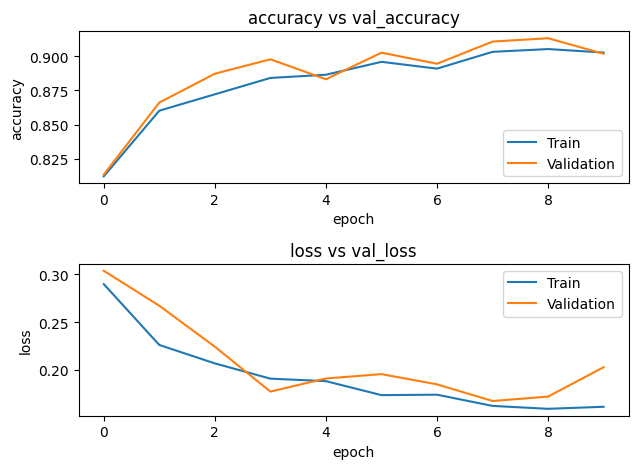

In [26]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

**Few take aways :**
- From the Training and Validation Accuracy graph above, our model does not seem to be overfitted, which is great!;
- Our Training and Validation Loss graph above also indicates a good learning rate, which is amazing !

---

### **Prediction**
>Finally, let us test our model against more random samples from the test data !

39/39 [==============================] - 39s 986ms/step


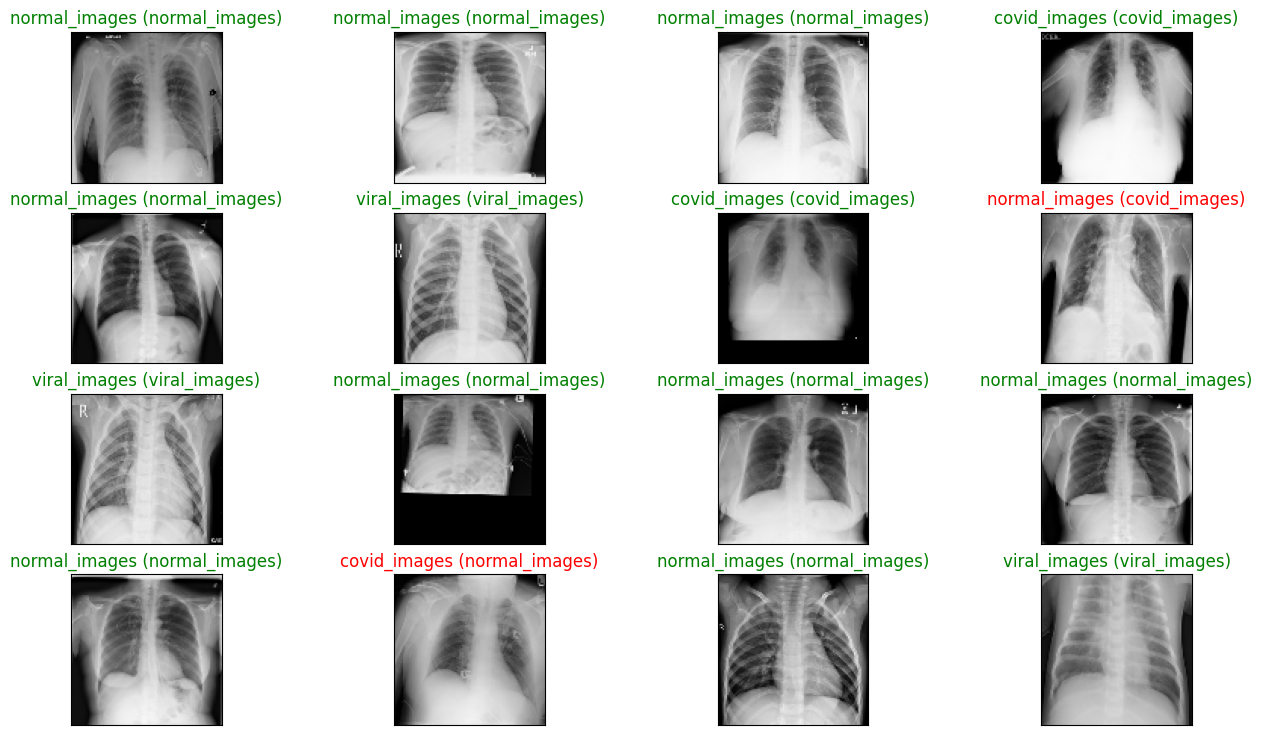

In [27]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(Model.predict(X_test))

### Confusion Matrix
> Please note that, **_0_ and _1_ values represent _Covid-19_ and _No_findigs_ respectively**  .

39/39 [==============================] - 39s 1s/step


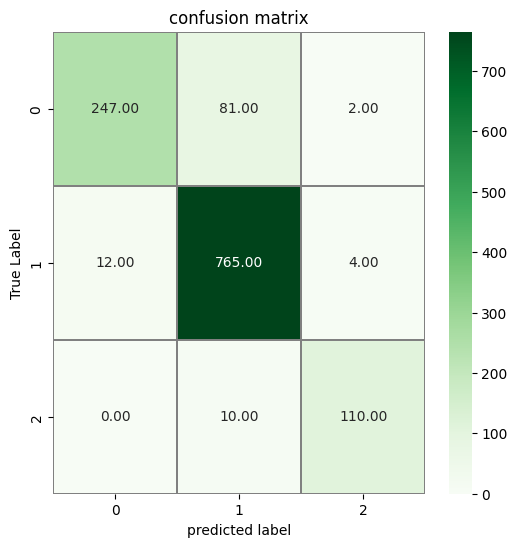

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (6,6))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

**Few Take aways:**
- The easiest to detect is **Covid-19**, i.e. if you are infected then you are really infected
- It is clear that the model can sometimes deceive in stating that a person is not infected but it could be. Anyways, we need the expertise to explain this kind of stuff, especially when it comes to medicine. **Just we must not forget that we do not have enough images for Covid-19**.

- Our confusion matrix indicates that there are disturbing errors. which is Great!.

> You can check the classification report below for more information !

In [29]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

               precision    recall  f1-score   support

 covid_images       0.95      0.75      0.84       330
normal_images       0.89      0.98      0.93       781
 viral_images       0.95      0.92      0.93       120

     accuracy                           0.91      1231
    macro avg       0.93      0.88      0.90      1231
 weighted avg       0.92      0.91      0.91      1231



### Loading the model
> Here we're gonna load our best model trained befor, then make some predictions with it !

In [30]:
my_model=keras.models.load_model("E:/COVID-19-Detection/Covid_vgg19.h5")

39/39 [==============================] - 37s 945ms/step


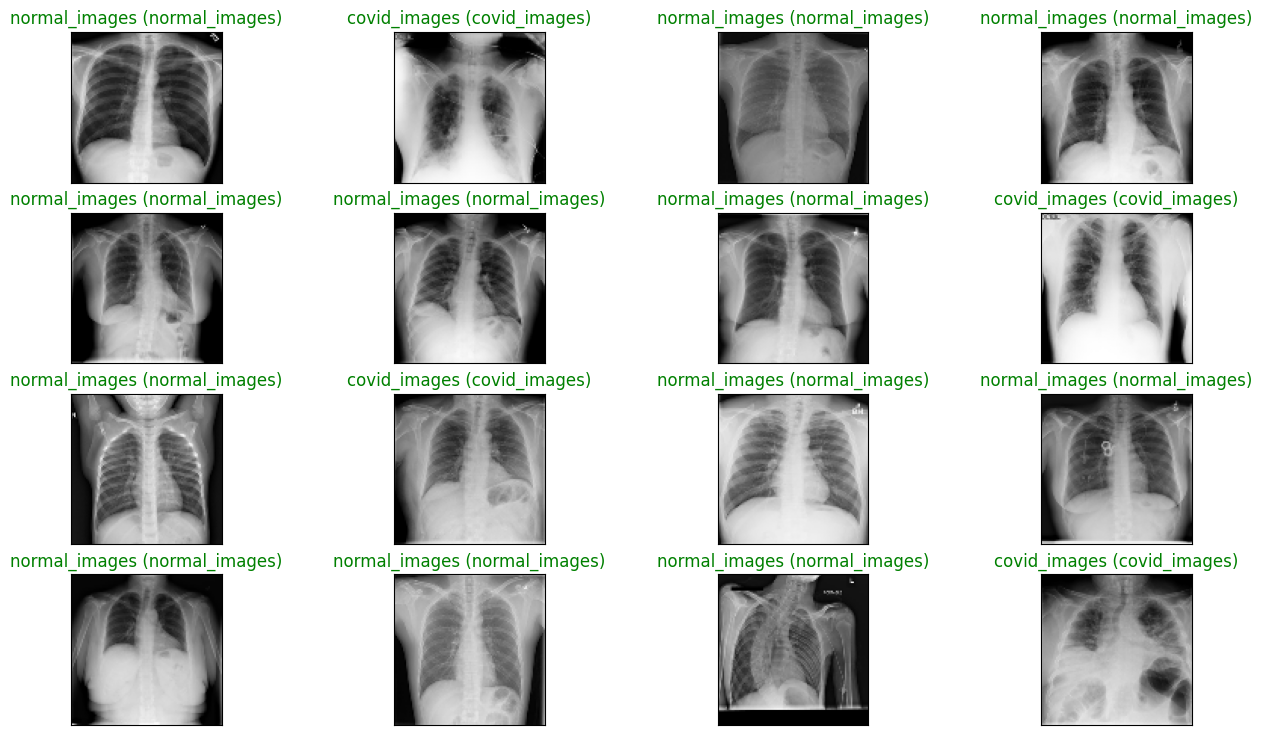

In [31]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))